In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})


import nfp
print(f"nfp version: {nfp.__version__}")
from preprocess_inputs_spin_bv import preprocessor
preprocessor.from_json('inputs/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

%matplotlib inline

nfp version: 0.2.0


In [2]:
os.getcwd()

'/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc'

In [4]:
!nvidia-smi

Wed Feb 17 15:11:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 29%   42C    P2    35W / 250W |    609MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
model_name = "20210216_spin_bv_lc"
inputs_dir = f"inputs/{model_name}"
outputs_dir = f"outputs/{model_name}"
num_new_train = len(np.load(f'{inputs_dir}/split_spin_bv.npz', allow_pickle=True)['train_new'])
# split the 3K new calculations into groups evenly spaced by log
num_train_list = np.logspace(2, np.log10(num_new_train), num=6, dtype=int)
# make sure the last entry includes all training data
num_train_list[-1] = num_new_train
num_train_list

array([ 100,  200,  401,  803, 1609, 3223])

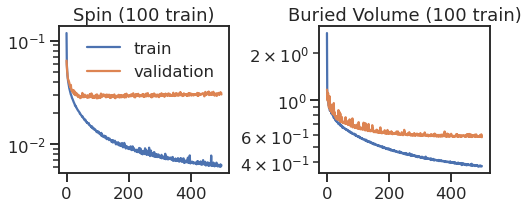

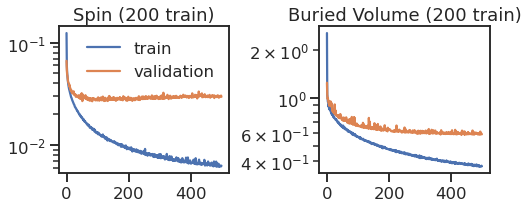

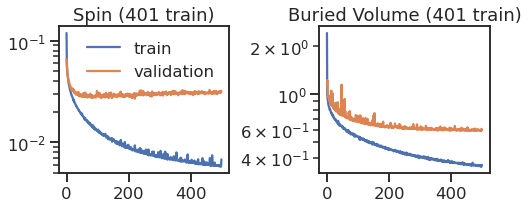

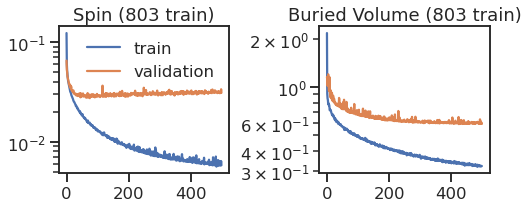

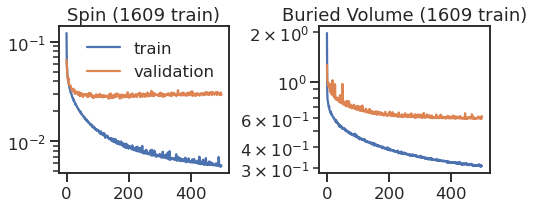

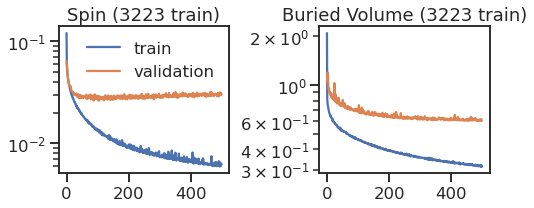

In [6]:
for num in num_train_list:
    fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

    log2 = pd.read_csv(f'{outputs_dir}/n_{num}/log.csv', error_bad_lines=False).set_index('epoch')

    axs[0].plot(log2['spin_loss'], label='train')
    axs[0].plot(log2['val_spin_loss'], label='validation')

    axs[0].set_title(f'Spin ({num} train)')

    axs[1].plot(log2['bur_vol_loss'])
    axs[1].plot(log2['val_bur_vol_loss'])

    axs[1].set_title(f'Buried Volume ({num} train)')

    for ax in axs:
        ax.set_yscale('log')

    axs[0].legend()
#     plt.suptitle(f"{num} new training examples", fontsize=18)

#     print(log2.min())


    plt.tight_layout()
    # plt.xlim([0, 10])

In [7]:
# Load the "new test" set which is the 500 of the most recent DFT calculations we left out 
test = np.load(f'{inputs_dir}/split_spin_bv.npz', allow_pickle=True)['test_new']

In [8]:
# Load the  values
# cdf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
# cdf_spin = cdf_spin[cdf_spin.atom_type != 'H']

# cdf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_buried_volume.csv.gz', index_col=0)
# cdf = cdf_spin.merge(cdf_bv, on=['smiles', 'atom_index'], how='left')

# cdf['fractional_spin'] = cdf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

from preprocess_inputs_spin_bv import new_data
cdf = new_data

cdf_test = cdf[cdf.smiles.isin(test)].copy()

In [9]:
cdf.head()

,smiles,atom_index,spin,buried_vol
0,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,0,0.085155,40.057887
1,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1,0.024316,54.431655
2,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,2,0.009385,41.549793
3,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,3,0.001184,32.768445
4,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,4,0.345404,62.511166


In [10]:
test_dataset_gen = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [11]:
def parse_example(example):
    parsed = tf.io.parse_single_example(example, features={
        **preprocessor.tfrecord_features,
        **{'spin': tf.io.FixedLenFeature([], dtype=tf.string),
           'bur_vol': tf.io.FixedLenFeature([], dtype=tf.string)}})

    # All of the array preprocessor features are serialized integer arrays
    for key, val in preprocessor.tfrecord_features.items():
        if val.dtype == tf.string:
            parsed[key] = tf.io.parse_tensor(
                parsed[key], out_type=preprocessor.output_types[key])
    
    # Pop out the prediction target from the stored dictionary as a seperate dict
    parsed['spin'] = tf.io.parse_tensor(parsed['spin'], out_type=tf.float64)
    parsed['bur_vol'] = tf.io.parse_tensor(parsed['bur_vol'], out_type=tf.float64)
    
    spin = parsed.pop('spin')
    bur_vol = parsed.pop('bur_vol')
    targets = {'spin': spin, 'bur_vol': bur_vol}
    
    return parsed, targets

In [12]:
# Here, we have to add the prediction target padding onto the input padding
padded_shapes = (preprocessor.padded_shapes(max_atoms=None, max_bonds=None),
                 {'spin': [None], 'bur_vol': [None]})

padding_values = (preprocessor.padding_values,
                  {'spin': tf.constant(np.nan, dtype=tf.float64),
                   'bur_vol': tf.constant(np.nan, dtype=tf.float64)})

batch_size = 128
test_dataset = tf.data.TFRecordDataset(f'{inputs_dir}/tfrecords/valid_new.tfrecord.gz', compression_type='GZIP')\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .padded_batch(batch_size=batch_size,
                  padded_shapes=padded_shapes,
                  padding_values=padding_values)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# store the predictions for each of the points along the learning curve
learning_curve_pred = {}
learning_curve_pred_gen = {}
for num_train in num_train_list:
    model = tf.keras.models.load_model(
        f'{outputs_dir}/n_{num_train}/best_model.hdf5',
        custom_objects={**nfp.custom_objects,
                        **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

    new_model = tf.keras.Model(model.inputs[:3], [tf.nn.softmax(model.outputs[0]), model.outputs[1]])

    predicted_spin_logits, predicted_bur_vol = new_model.predict(test_dataset, verbose=1)
#     predicted_fractional_spins = tf.nn.softmax(predicted_spin_logits)
    pred_spins = predicted_spin_logits.squeeze()
    pred_bur_vols = predicted_bur_vol.squeeze()
    learning_curve_pred[num_train] = (pred_spins, pred_bur_vols)
    
    predicted_spin_logits, predicted_bur_vol = new_model.predict(test_dataset_gen, verbose=1)
    pred_spins = predicted_spin_logits.squeeze()
    pred_bur_vols = predicted_bur_vol.squeeze()
    learning_curve_pred_gen[num_train] = (pred_spins, pred_bur_vols)

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['bond_indices', 'n_atom', 'n_bond'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


4/4 [==============================] - 0s 29ms/step


/lustre/eaglefs/projects/rlmolecule/jlaw/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


4/4 [==============================] - 0s 70ms/step


In [72]:
(pred_spins, pred_bur_vols) = learning_curve_pred[100]
(pred_spins2, pred_bur_vols2) = learning_curve_pred_gen[100]
pred_spins[0]

array([3.1020105e-14, 5.0875349e-11, 9.9780744e-01, 2.1926090e-03,
       0.0000000e+00, 1.2017546e-08, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 3.3808107e-22, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32)

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-scatter-n100.jpg


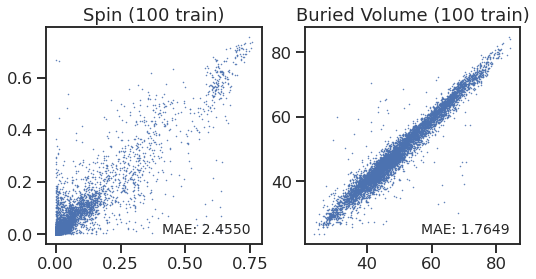

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-scatter-n200.jpg


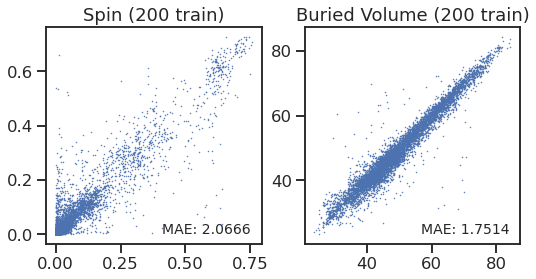

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-scatter-n401.jpg


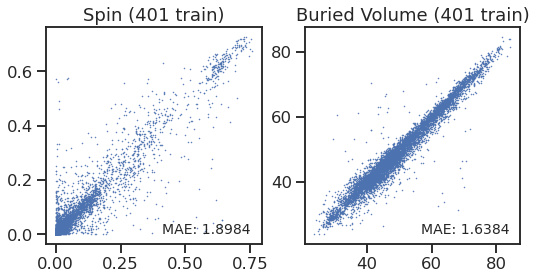

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-scatter-n803.jpg


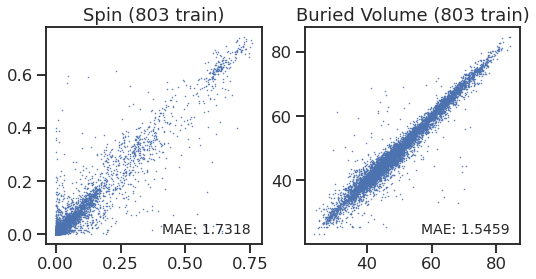

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-scatter-n1609.jpg


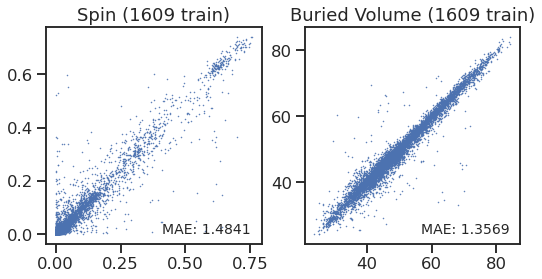

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-scatter-n3223.jpg


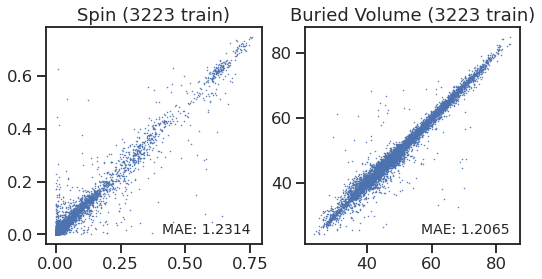

In [45]:
spin_mae_list = []
bv_mae_list = []
for num_train in num_train_list:
#     pred_spins, pred_bur_vols = learning_curve_pred[num_train]
    pred_spins, pred_bur_vols = learning_curve_pred_gen[num_train]
#     cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
    cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='spin')
    cdf_test_pivot_spins = cdf_test_pivot_spins.reindex(test)

    cdf_test_pivot_bur_vol = cdf_test.pivot(index='smiles', columns='atom_index', values='buried_vol')
    cdf_test_pivot_bur_vol = cdf_test_pivot_bur_vol.reindex(test)
    # compute the Mean Average Error
    # multiply by 100 so both are percentages
    spin_mae = pd.Series(cdf_test_pivot_spins.values.flatten() - pred_spins.flatten()).dropna().abs().mean() * 100
    bv_mae = pd.Series(cdf_test_pivot_bur_vol.values.flatten() - pred_bur_vols.flatten()).dropna().abs().mean()
    # and store for later
    spin_mae_list.append(spin_mae)
    bv_mae_list.append(bv_mae)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
    axs[0].plot(cdf_test_pivot_spins.values.flatten(), pred_spins.flatten(), '.', ms=1)
    axs[0].text(.95, .05, f'MAE: {spin_mae:.4f}', ha='right',
                transform=axs[0].transAxes, fontsize=14)

    axs[1].plot(cdf_test_pivot_bur_vol.values.flatten(), pred_bur_vols.flatten(), '.', ms=1)
    axs[1].text(.95, .05, f'MAE: {bv_mae:.4f}', ha='right',
                transform=axs[1].transAxes, fontsize=14)

    axs[0].set_title(f'Spin ({num_train} train)')
    axs[1].set_title(f'Buried Volume ({num_train} train)')
    out_file = f'{outputs_dir}/2021-02-16-spin-bv-scatter-n{num_train}.jpg'
    print(os.path.abspath(out_file))
    fig.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
spin_mae_list

[0.09594619435985256,
 0.09605013731473346,
 0.09671288742149146,
 0.09661151122427915,
 0.09671846221733131,
 0.09650824420525185]

In [17]:
bv_mae_list

[11.77120499427812,
 11.85058388025868,
 11.799444234943817,
 11.829318755910124,
 11.787331178303223,
 11.785393785328298]

In [46]:
# compute a regression line of the MAE points
from scipy import stats

# spin_mae_log,bv_mae_log,num_train_log =[],[],[]
# for i, num_train in enumerate(num_train_list):
#     spin_mae_log.append(np.log10(spin_mae_list[i]))
#     bv_mae_log.append(np.log10(bv_mae_list[i]))
#     num_train_log.append(np.log10(num_train))
spin_mae_log = spin_mae_list
bv_mae_log = bv_mae_list
num_train_log = num_train_list
print(num_train_log,spin_mae_log,bv_mae_log)

X = np.array(num_train_log)
Yspin = np.array(spin_mae_log)
Ybv = np.array(bv_mae_log)
# print(X,Yspin,Ybv)

slope_spin, intercept_spin, r_value_spin, p_value_spin, std_err_spin = stats.linregress(X,Yspin)
slope_bv, intercept_bv, r_value_bv, p_value_bv, std_err_bv = stats.linregress(X,Ybv)

print('intercept_spin:', intercept_spin)
print('intercept_bv:', intercept_bv)

print('slope_spin:', slope_spin)
print('slope_bv:', slope_bv)

[ 100  200  401  803 1609 3223] [2.455021814999761, 2.066636908002544, 1.8984093261855282, 1.7318363728497093, 1.4840658515579297, 1.231394108457431] [1.7649132338427564, 1.7514400021608356, 1.638379941436115, 1.5459274514733954, 1.3568930037577651, 1.2064615295121264]
intercept_spin: 2.1525907042545556
intercept_bv: 1.734161122158455
slope_spin: -0.00032326070761907024
slope_bv: -0.00018007442720450388


/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_spin_bv_new_calcs_lc/outputs/20210216_spin_bv_lc/2021-02-16-spin-bv-lc-MAE.jpg


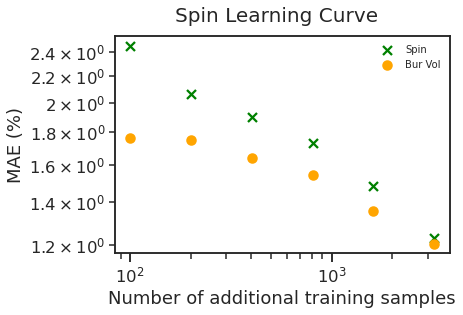

In [60]:
# now plot the learning curve of the MAE
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(num_train_list, spin_mae_list, c='green', marker="x", label='Spin')
ax1.scatter(num_train_list, bv_mae_list, c='orange', marker="o", label='Bur Vol')

z_spin = np.polyfit(num_train_list,spin_mae_list, 1)
z_bv = np.polyfit(num_train_list,bv_mae_list, 1)
p_spin = np.poly1d(z_spin)
p_bv = np.poly1d(z_bv)

# ax1.plot(num_train_list, p_spin(np.asarray(num_train_list)), c='green', label='Spin-fit',linestyle='dashed')
# ax1.plot(num_train_list, p_bv(np.asarray(num_train_list)), c='orange', label='BV-fit',linestyle='dashed')

fig.suptitle('Spin Learning Curve', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xlabel('Number of additional training samples')
plt.ylabel('MAE (%)')
plt.legend(fontsize=10)
out_file = f'{outputs_dir}/2021-02-16-spin-bv-lc-MAE.jpg'
print(os.path.abspath(out_file))
fig.savefig(out_file, dpi=300, bbox_inches='tight')
plt.show()